# <h1><center>KBB Used vs New Car Cost Analysis</center></h1>

## Introduction

As the state of the economy and car market changes, the price of automobiles varies with lots of uncertainty. As someone who is curious how much my current car is worth and how much I can expect to pay for a car at this moment, this project reveals current prices and trends of the new and used car market. A cost analysis is accomplished by web scraping data from Kelly Blue Book, a service that posts new and used vehicles listed by owner and dealer for sale.

## Table of Contents:
* [Extracting Data](#first-bullet1)
* [Cleaning Data](#second-bullet1)
* [Visualization and Analysis](#third-bullet1)

## Extracting Data <a class="anchor" id="first-bullet1"></a>

In [39]:
# Import relevant libraries

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
s = Service(ChromeDriverManager().install())

from bs4 import BeautifulSoup as bs
import requests

In [40]:
# Running the Chrome webdriver via Selenium
driver = webdriver.Chrome(service=s)

# Accessing Kelly Blue Book's most recent posts in the Austin, TX area
driver.get('https://www.kbb.com/cars-for-sale/austin-tx/?isNewSearch=false&listingTypes=NEW%2CUSED&marketExtension=include&numRecords=100&searchRadius=75&showAccelerateBanner=false&sortBy=mileageDESC&zip=78701')

time.sleep (4)

# From the webpage, pulling the html and saving it
html = driver.page_source
driver.quit()

In [42]:
# Using Beautiful Soup, the html is parsed
soup = bs(html)

# Pulling the title of each post
title = soup.find_all("h3", {"class": "text-bold text-size-400 text-size-sm-500 link-unstyled"})
title_clean = []
for a in title:
    title_clean.append(a.get_text())
print(len(title))

# Pulling the price of each car
price = soup.find_all("span", {"class": "first-price"})
price_clean = []
for a in price:
    price_clean.append(a.get_text())
print(len(price))

# Pulling the mileage of each car. For new cars, the mileage is not posted because it is zero. This is why the length of the mileage list is less than the title and price lists.
mileage = soup.find_all("ul", {"class": "list list-inline display-inline margin-bottom-0 pipe-delimited text-gray text-size-300"})
mileage_clean = []
for a in mileage:
    mileage_clean.append(a.get_text())
print(len(mileage))

104
94
102


## Cleaning Data  <a class="anchor" id="second-bullet1"></a>

In [43]:
# putting into pandas df
import pandas as pd
df = pd.DataFrame(list(zip(title_clean,price_clean)),columns=['title','price'])
df

,title,price
0,Used 2005 Ford Escape XLT,"7,286"
1,Used 2022 Chevrolet Silverado 1500 LT,"50,639"
2,New 2023 Ford F150 XLT,"62,995"
3,Used 2018 Mercedes-Benz GLC 300,"26,991"
4,Used 2018 GMC Sierra 1500 SLT,"39,994"
...,...,...
89,Used 2013 Toyota RAV4 XLE,"21,985"
90,Used 2011 Ford F350 XL,"5,950"
91,Used 2012 RAM 3500 SLT,"8,998"
92,Used 2000 Toyota 4Runner Limited,"17,991"


In [44]:
# Cleaning the data
new_used_or_certified = []
year = []
sorted_by = []
for a in df['title']:
    new_used_or_certified.append(a.split()[0]) # Taking out the year from each title
    year.append(a.split()[1]) # Taking out whether the car is new or used from each title
    sorted_by.append('Mileage - Highest')
for i, a in enumerate(df['price']):
    if a[-4:] == 'MSRP':
        df['price'].iloc[i] = a[:-4] # Removing 'MSPR' from the prices that contain the letters
df['new_used_or_certified'] = new_used_or_certified
df['year'] = year
df['sorted_by'] = sorted_by

In [45]:
# Adding a column for vehicle mileage. Only used vehicles have mileage

# The webscraper pulls in a shortened list of vehicle mileage because only a fraction of the listed vehicles are used.
mileage_extra_rows = [0]*(len(df.title)-len(mileage_clean)) # Extending the length of the mileage list to match the rest of the dataframe.
for a in mileage_extra_rows:
    mileage_clean.append(0)

mileage_all = []

# Looping through the list of new and used vehicles and assigning the mileage.
for a,b in zip(df['new_used_or_certified'],mileage_clean): 
    if a == 'Used':
        mileage_all.append(b)
    else:
        mileage_all.append(0)

df['mileage'] = mileage_all

df.head() # Preview the dataframe

,title,price,new_used_or_certified,year,sorted_by,mileage
0,Used 2005 Ford Escape XLT,"7,286",Used,2005,Mileage - Highest,"6,207 miles"
1,Used 2022 Chevrolet Silverado 1500 LT,"50,639",Used,2022,Mileage - Highest,11 miles
2,New 2023 Ford F150 XLT,"62,995",New,2023,Mileage - Highest,0
3,Used 2018 Mercedes-Benz GLC 300,"26,991",Used,2018,Mileage - Highest,"559,798 miles"
4,Used 2018 GMC Sierra 1500 SLT,"39,994",Used,2018,Mileage - Highest,"400,000 miles"


In [46]:
# Importing a list of automobile manufacturers from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_current_automobile_manufacturers_by_country"
data = requests.get(url).text
soup = bs(data, 'html.parser')
makes = soup.find_all("a")
car_makes = []
for a in makes:
    if (len(str(a.text))<2):
        pass
    else:
        car_makes.append(a.text)

# Assigning manufacturer names based on posttitle
testindex = []
test = []

for i,a in enumerate(df['title']):
    for b in a.split():
        for c in car_makes:
            for d in c.split():
                if d == 'New':
                    pass
                elif d == b:
                    testindex.append(i)
                    test.append(d)
                else:
                    pass
# Creating a dataframe for the car manufacturer names and                 
d = {'index':testindex,'car_make':test}
dfcm = pd.DataFrame(data=d)
dfcm['car_make'] = dfcm['car_make'].replace('Abarth','Fiat')
dfcm['car_make'] = dfcm['car_make'].replace('Land','Land Rover')
dfcm = dfcm.drop_duplicates()
dfcm = dfcm.set_index('index') # Changing the index of the manufacturer df so the join is by index
df = df.join(dfcm)
df.head()

,title,price,new_used_or_certified,year,sorted_by,mileage,car_make
0,Used 2005 Ford Escape XLT,"7,286",Used,2005,Mileage - Highest,"6,207 miles",Ford
1,Used 2022 Chevrolet Silverado 1500 LT,"50,639",Used,2022,Mileage - Highest,11 miles,Chevrolet
2,New 2023 Ford F150 XLT,"62,995",New,2023,Mileage - Highest,0,Ford
3,Used 2018 Mercedes-Benz GLC 300,"26,991",Used,2018,Mileage - Highest,"559,798 miles",Mercedes-Benz
4,Used 2018 GMC Sierra 1500 SLT,"39,994",Used,2018,Mileage - Highest,"400,000 miles",GMC


In [47]:
df

,title,price,new_used_or_certified,year,sorted_by,mileage,car_make
0,Used 2005 Ford Escape XLT,"7,286",Used,2005,Mileage - Highest,"6,207 miles",Ford
1,Used 2022 Chevrolet Silverado 1500 LT,"50,639",Used,2022,Mileage - Highest,11 miles,Chevrolet
2,New 2023 Ford F150 XLT,"62,995",New,2023,Mileage - Highest,0,Ford
3,Used 2018 Mercedes-Benz GLC 300,"26,991",Used,2018,Mileage - Highest,"559,798 miles",Mercedes-Benz
4,Used 2018 GMC Sierra 1500 SLT,"39,994",Used,2018,Mileage - Highest,"400,000 miles",GMC
...,...,...,...,...,...,...,...
89,Used 2013 Toyota RAV4 XLE,"21,985",Used,2013,Mileage - Highest,"236,000 miles",Toyota
90,Used 2011 Ford F350 XL,"5,950",Used,2011,Mileage - Highest,"236,000 miles",Ford
91,Used 2012 RAM 3500 SLT,"8,998",Used,2012,Mileage - Highest,"235,982 miles",NaN
92,Used 2000 Toyota 4Runner Limited,"17,991",Used,2000,Mileage - Highest,"235,691 miles",Toyota


In [48]:
# Exporting to a csv
import datetime
date_today = [datetime.date.today()]*len(df)
df['date_post'] = date_today
df.to_csv('KBB Web Scraping Data v2.csv', mode='a', index=False, header=False)
df = pd.read_csv(r'C:\Users\ngret\DataPortfolio\Data-Analytics-Portfolio\Used vs New Car Cost Analysis\KBB Web Scraping Data v2.csv') # Bring full historical csv back in as df

In [95]:
import pandas as pd

df = pd.read_csv(r'C:\Users\ngret\DataPortfolio\Data-Analytics-Portfolio\Used vs New Car Cost Analysis\KBB Web Scraping Data v2.csv') # Bring full historical csv back in as df
df = df[df['car_make'] != 'and']
df = df[df['car_make'] != '&']
df = df[df['car_make'] != 'Truck']
df['car_make'].unique()

array(['Ford', 'Toyota', 'Lamborghini', 'Mercedes-Benz', 'Land Rover',
       'Rover', 'Chevrolet', 'Cadillac', 'BMW', 'Lincoln', 'GMC',
       'Shelby', 'Jeep', nan, 'Dynamic', 'Tesla', 'Dodge', 'SRT', 'Audi',
       'Nissan', 'Hyundai', 'Volvo', 'Polestar', 'Chrysler', 'Isuzu',
       'Suzuki', 'Mitsubishi', 'Honda', 'Volkswagen', 'Buick', 'Jaguar',
       'Kia', 'Subaru', 'Car', 'Ram', 'Lexus'], dtype=object)

In [96]:
listed_price = []

for a in df['price']:
    listed_price.append(int(a.replace(',','')))
df['listed_price'] = listed_price

mileage_num = []
for a in df['mileage']:
    mileage_num.append(int(a.replace(' miles','').replace(',','')))
df['mileage_num'] = mileage_num

In [97]:
df

,title,price,new_used_or_certified,year,sorted_by,mileage,car_make,scrape_date,listed_price,mileage_num
0,Used 2005 Ford Escape XLT,"7,286",Used,2005,Date - Newest,"22,230 miles",Ford,6/16/2023,7286,22230
1,Used 2021 Ford Bronco Sport Big Bend,"30,700",Used,2021,Date - Newest,"13,570 miles",Ford,6/16/2023,30700,13570
2,Certified 2022 Toyota Tundra SR5,"52,791",Certified,2022,Date - Newest,0,Toyota,6/16/2023,52791,0
3,Used 2023 Lamborghini Urus S,"329,888",Used,2023,Date - Newest,"9,300 miles",Lamborghini,6/16/2023,329888,9300
4,Used 2021 Lamborghini Urus,"254,888",Used,2021,Date - Newest,"23,336 miles",Lamborghini,6/16/2023,254888,23336
...,...,...,...,...,...,...,...,...,...,...
388,Used 2013 Toyota RAV4 XLE,"21,985",Used,2013,Mileage - Highest,"236,000 miles",Toyota,2023-06-16,21985,236000
389,Used 2011 Ford F350 XL,"5,950",Used,2011,Mileage - Highest,"236,000 miles",Ford,2023-06-16,5950,236000
390,Used 2012 RAM 3500 SLT,"8,998",Used,2012,Mileage - Highest,"235,982 miles",NaN,2023-06-16,8998,235982
391,Used 2000 Toyota 4Runner Limited,"17,991",Used,2000,Mileage - Highest,"235,691 miles",Toyota,2023-06-16,17991,235691


## Visualization  <a class="anchor" id="second-bullet1"></a>

Figure 1 informs car buyers considering Kelly Blue Book as a search tool of the following:
- The lowest priced cars are evenly distributed across all vehicle years.
- The newest posts on Kelly Blue Book are typically newer, more expensive cars.
- The oldest posts on Kelly Blue Book are typically of 4-9 year old cars.
- The highest mileage cars are not necessarily the least expensive as people may expect.

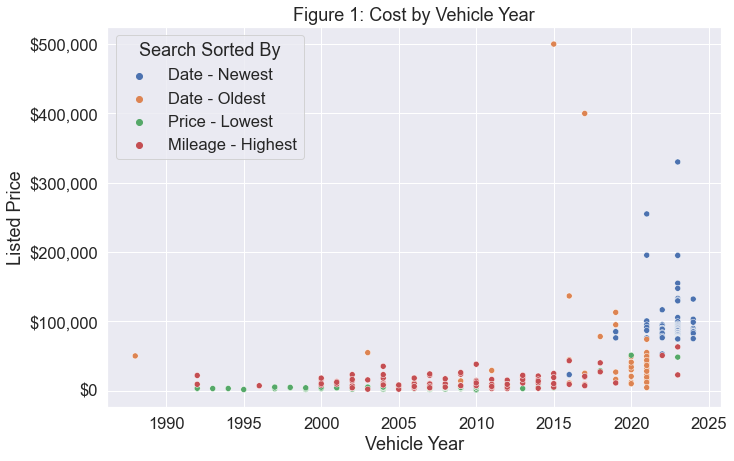

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

sns.set(font_scale=1.5)
figure_dims = (11, 7)
fig, ax = plt.subplots(figsize=figure_dims)
sns.scatterplot(ax=ax, data=df, x="year", y="listed_price", hue="sorted_by")
plt.title('Figure 1: Cost by Vehicle Year')
plt.xlabel('Vehicle Year')
plt.ylabel('Listed Price')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.legend(title="Search Sorted By")

Figure 2 informs car buyers considering Kelly Blue Book as a search tool of the following:
- The median price of new cars on KBB is more than 10 times greater then the median price of used cars. Whereas, the price of certified pre-owned cars is more than 3 times the cost of used cars.
- Used cars have the potential to cost as much as the median cost of new cars; although, the used cars exceeding the cost of the median cost of new cars are outliers.
- The distribution of the price of used cars is greater than the distribution of certified and new cars.

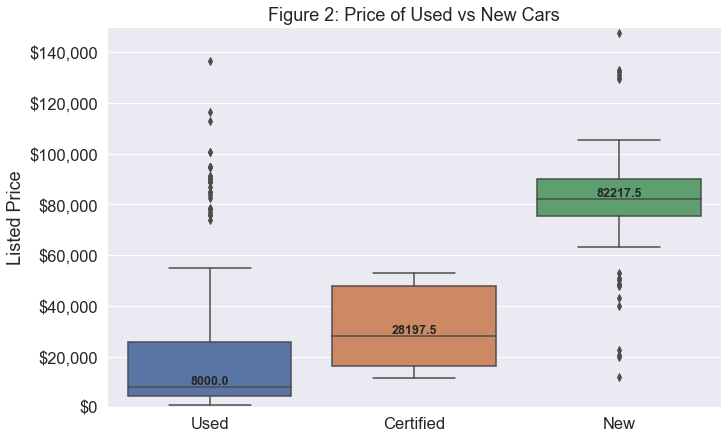

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(font_scale=1.5)
figure_dims = (11, 7)
fig, ax = plt.subplots(figsize=figure_dims)
sns.boxplot(ax=ax, data=df, x="new_used_or_certified", y="listed_price")
plt.title('Figure 2: Price of Used vs New Cars')
plt.xlabel('')
plt.ylabel('Listed Price')
plt.ylim([0, 150000])
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

medians = df.groupby(['new_used_or_certified'])['listed_price'].median()
medians = medians.reindex(['Used','Certified','New'])
vertical_offset = df['listed_price'].median() * 0.05 # offset from median for display

for xtick in [0,1,2]:
    ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',weight='semibold')

Figure 3 informs car buyers considering Kelly Blue Book as a search tool of the following:
- The trend line serves as a guide for determining which vehicles have a mileage less or greater than the average mileage for a given year. By comparing to the trendline, buyers may make a more informed decision of whether the vehicle has been driven further than the average distance.
- Vehicle mileage tends to increase with the age of the car. Although, the relationship between mileage and year is not deemed statistically significant because the coefficient of determination is 0.284. This relationship can be predicted with greater certainty with more data. A signicant number of 2010-2020 vehicles with greater than 200,000 miles influenced the slope the trendline.
- For cars of years 2000-2010, the relationship is more likely to be captured accurately by the trend line. 

In [149]:
average_mileage = df.groupby(['car_make','year'])['mileage_num'].mean()
average_mileage = average_mileage.reset_index(level=[0,1])
# average_mileage_toyota = average_mileage[average_mileage['car_make']=='Toyota']

R² = 0.2843608209931173


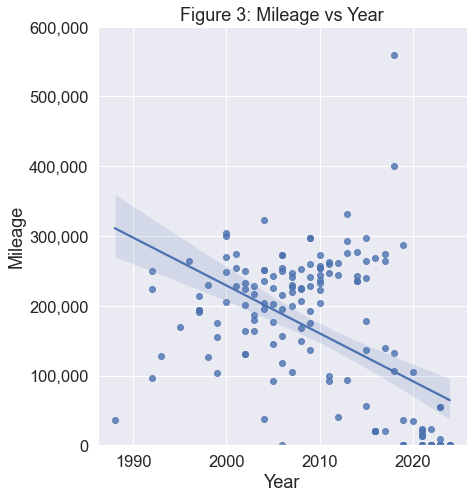

In [215]:
sns.set(font_scale=1.5)

fig3 = sns.lmplot(data=average_mileage, x="year", y="mileage_num", height=7)
plt.title('Figure 3: Mileage vs Year')
plt.xlabel('Year')
plt.ylabel('Mileage')

fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

ylabels = ['{:,}'.format(y) for y in np.arange(-100000,700000,100000)]
fig3.set_yticklabels(ylabels)
fig3.set(ylim=(0, None))

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
print("R\u00b2","=",r2(average_mileage['year'],average_mileage['mileage_num']))